In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
from analysis.fid import compute_fid
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import time

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_class_extension"

branched_before_model_path = os.path.join(models_base_path, "mnist_continuous_branched_3classes/1/last_ckpt.pth")
branched_after_model_path = os.path.join(models_base_path, "mnist_extension/8/last_ckpt.pth")
label_guided_before_model_path = os.path.join(models_base_path, "mnist_continuous_labelguided_3classes/3/last_ckpt.pth")
label_guided_afterone_model_path = os.path.join(models_base_path, "mnist_extension/9/last_ckpt.pth")
label_guided_afterall_model_path = os.path.join(models_base_path, "mnist_extension/10/last_ckpt.pth")

In [5]:
# Define the branches
classes_049 = [0, 4, 9]
branch_defs_049 = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.35, 0.5),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_0497 = [0, 4, 9, 7]
branch_defs_0497 = [
    ((0, 4, 7, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 7, 9), 0.38, 0.5),
    ((7,), 0, 0.38),
    ((4, 9), 0.35, 0.38),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_7 = [7]
branch_defs_7 = [
    ((7,), 0, 0.38)
]

branch_defs_049_linear = [
    ((0, 4, 9), 0, 1)
]

branch_defs_0497_linear = [
    ((0, 4, 7, 9), 0, 1)
]

In [6]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_class_extension"

os.makedirs(out_path, exist_ok=True)

### Create data loaders

In [7]:
dataset_049 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_0497 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_7 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds_049 = np.isin(dataset_049.targets, classes_049)
dataset_049.data = dataset_049.data[inds_049]
dataset_049.targets = dataset_049.targets[inds_049]
inds_0497 = np.isin(dataset_0497.targets, classes_0497)
dataset_0497.data = dataset_0497.data[inds_0497]
dataset_0497.targets = dataset_0497.targets[inds_0497]
inds_7 = np.isin(dataset_7.targets, classes_7)
dataset_7.data = dataset_7.data[inds_7]
dataset_7.targets = dataset_7.targets[inds_7]

data_loader_049 = torch.utils.data.DataLoader(dataset_049, batch_size=128, shuffle=True, num_workers=2)
data_loader_0497 = torch.utils.data.DataLoader(dataset_0497, batch_size=128, shuffle=True, num_workers=2)
data_loader_7 = torch.utils.data.DataLoader(dataset_7, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader_049))[0].shape[1:]

In [8]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c, classes):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Import models

In [10]:
branched_before_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, branched_before_model_path
).to(DEVICE)
branched_after_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, branched_after_model_path
).to(DEVICE)

label_guided_before_model = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat, label_guided_before_model_path
).to(DEVICE)
label_guided_afterone_model = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat, label_guided_afterone_model_path
).to(DEVICE)
label_guided_afterall_model = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat, label_guided_afterall_model_path
).to(DEVICE)

### Introducing a new digit class

**Fine-tune new branch on branched model**

Sampling class: 0


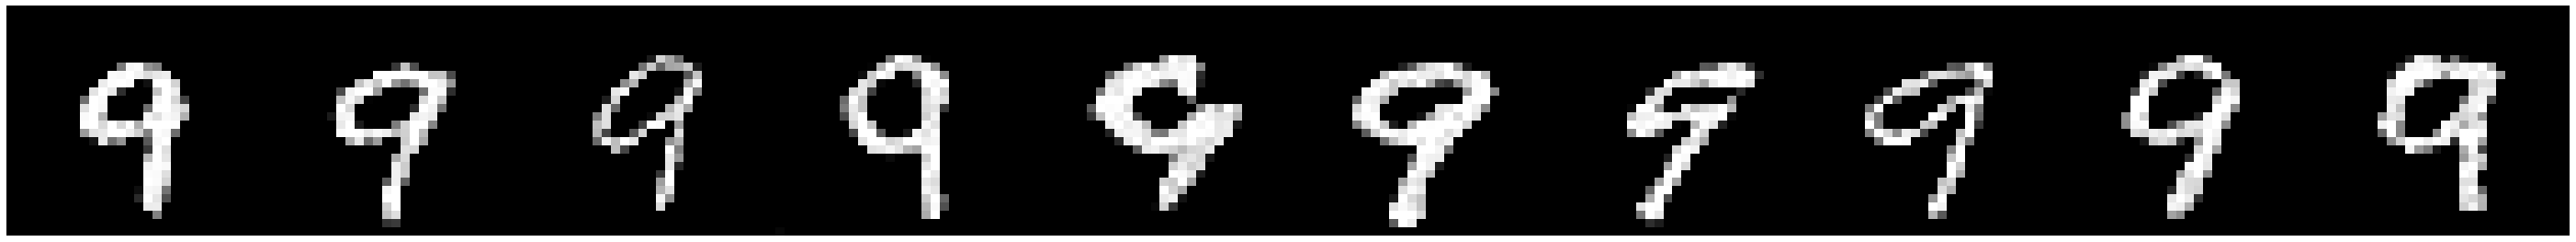

In [11]:
# Samples before fine-tuning
branched_before_samples = {}
for class_to_sample in classes_049:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_before_model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_049),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    branched_before_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 1), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "mnist_class_extension_branched_before_%d.svg" % class_to_sample),
        format="svg"
    )
    plt.show()

Sampling class: 0


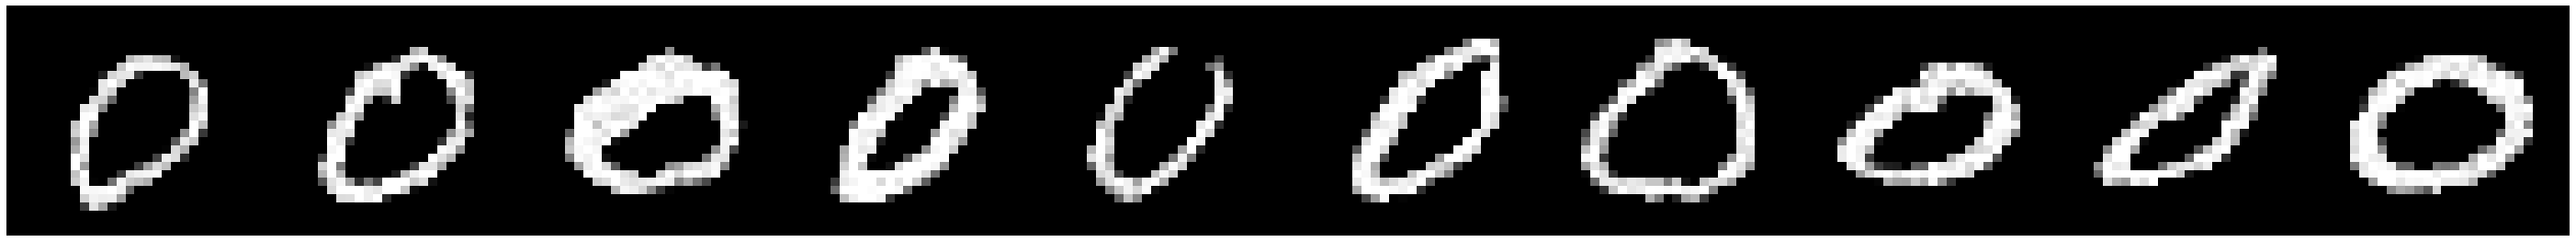

Sampling class: 4


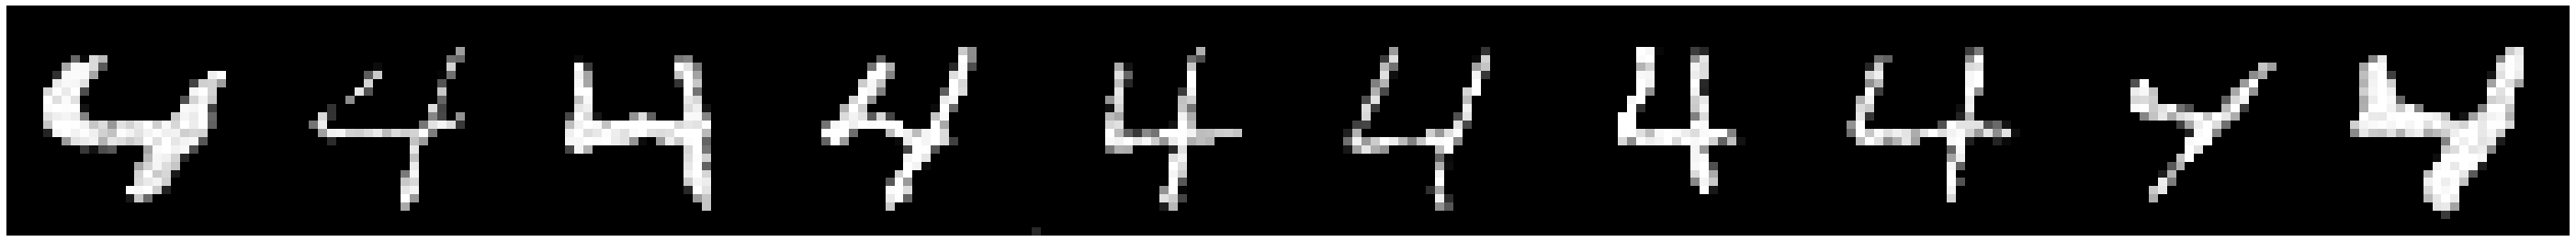

Sampling class: 9


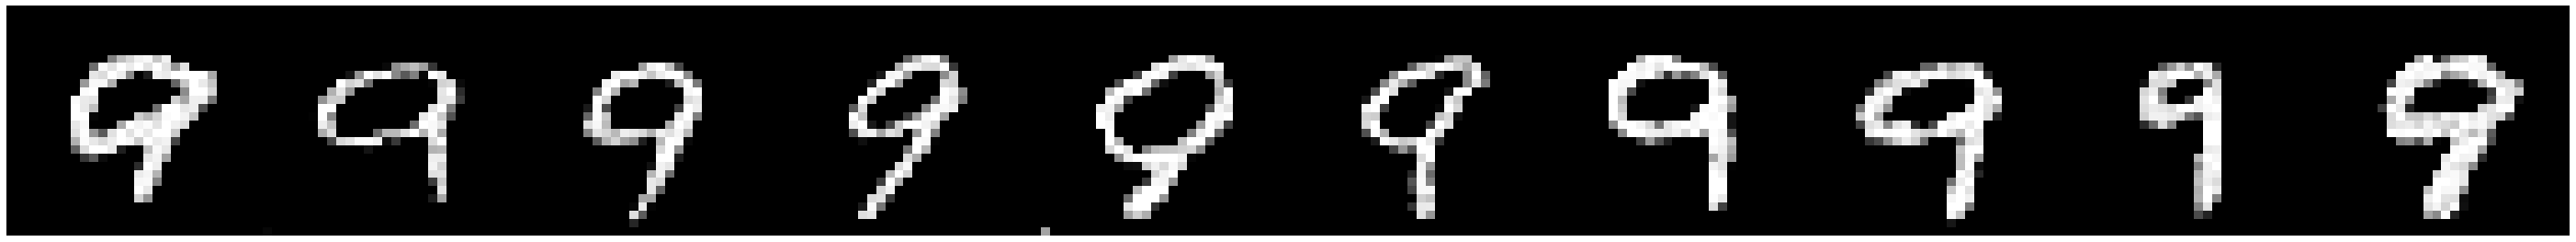

Sampling class: 7


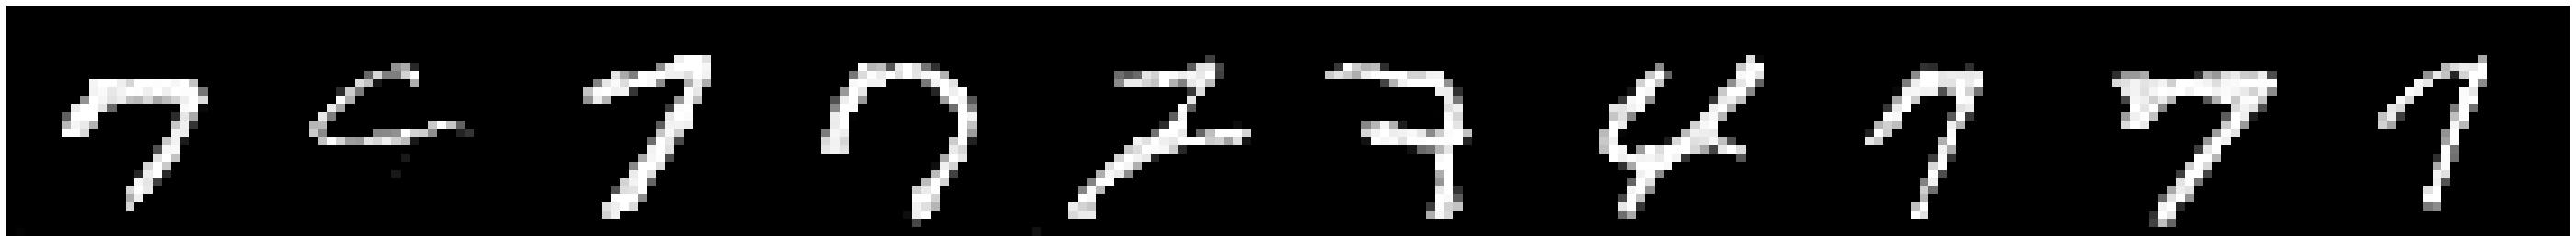

In [12]:
# Samples after fine-tuning
branched_after_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_after_model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    branched_after_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 1), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "mnist_class_extension_branched_after_%d.svg" % class_to_sample),
        format="svg"
    )
    plt.show()

#### Train additional digit on label-guided (linear) model

Sampling class: 0


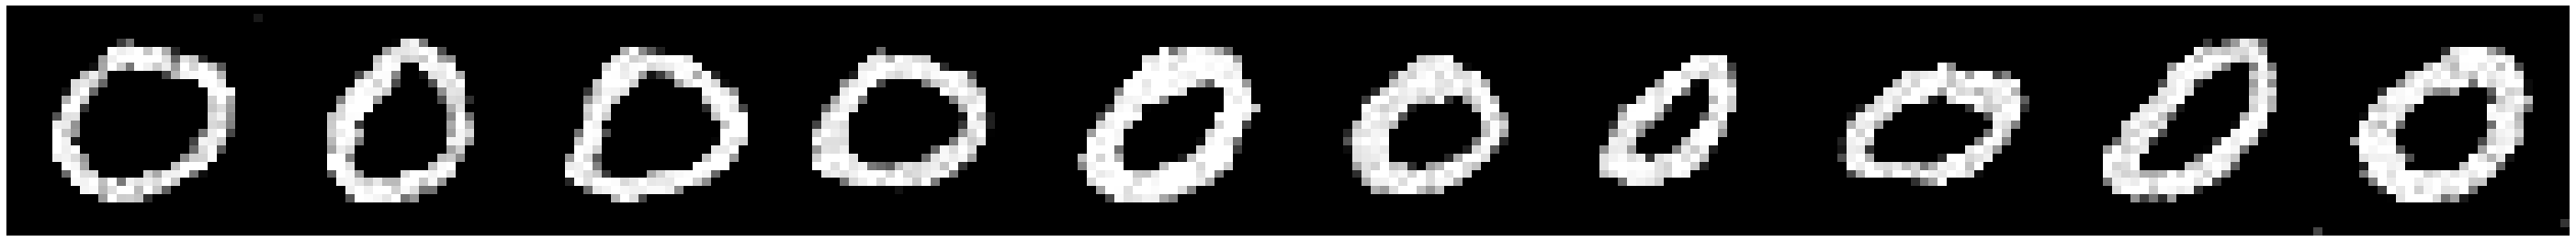

Sampling class: 4


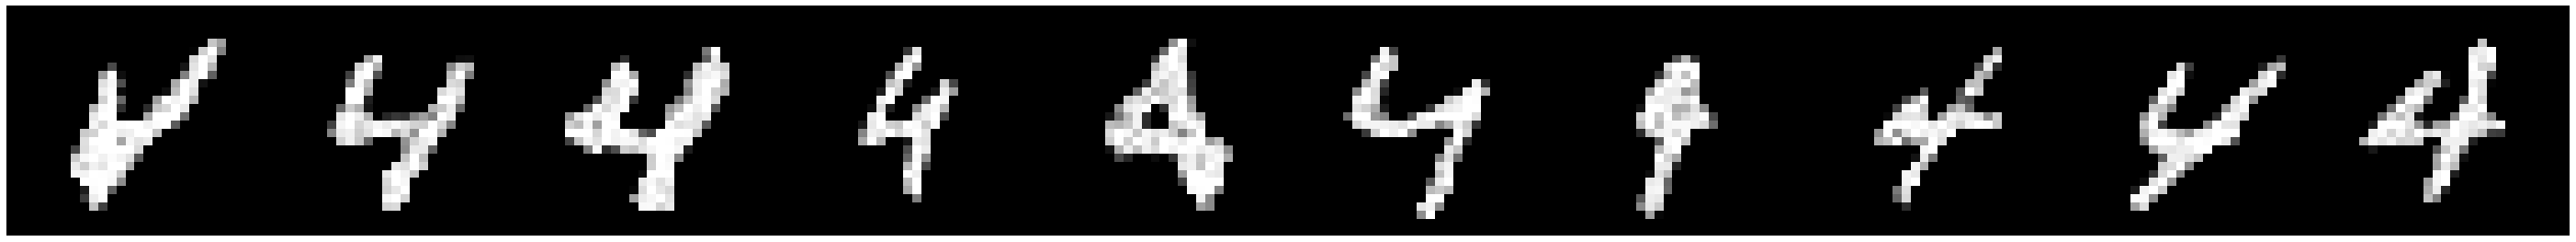

Sampling class: 9


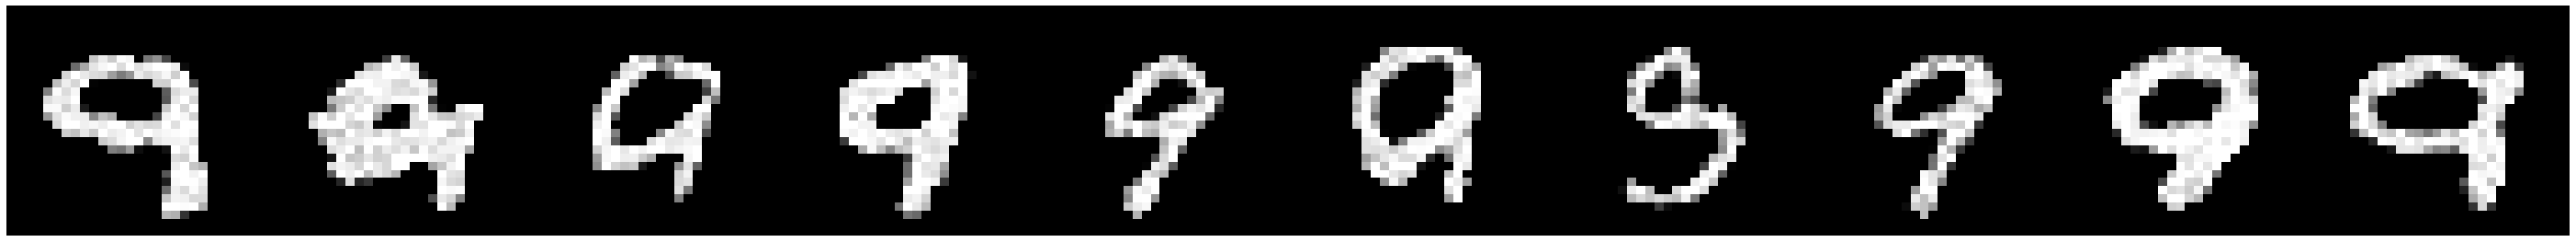

Sampling class: 7


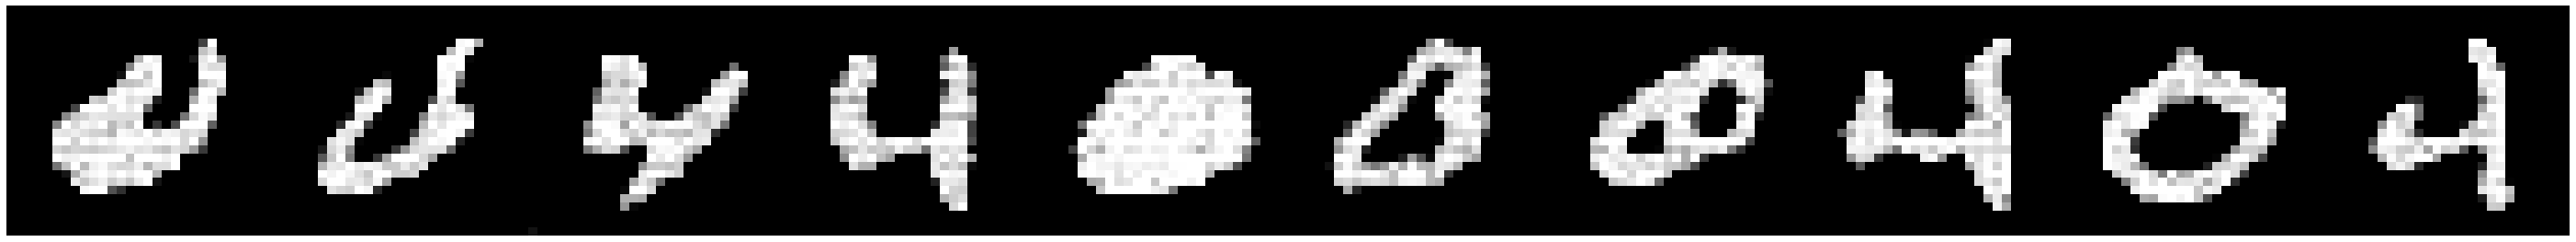

In [13]:
label_guided_before_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_before_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_before_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 1), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "mnist_class_extension_label_guided_before_%d.svg" % class_to_sample),
        format="svg"
    )
    plt.show()

Sampling class: 0


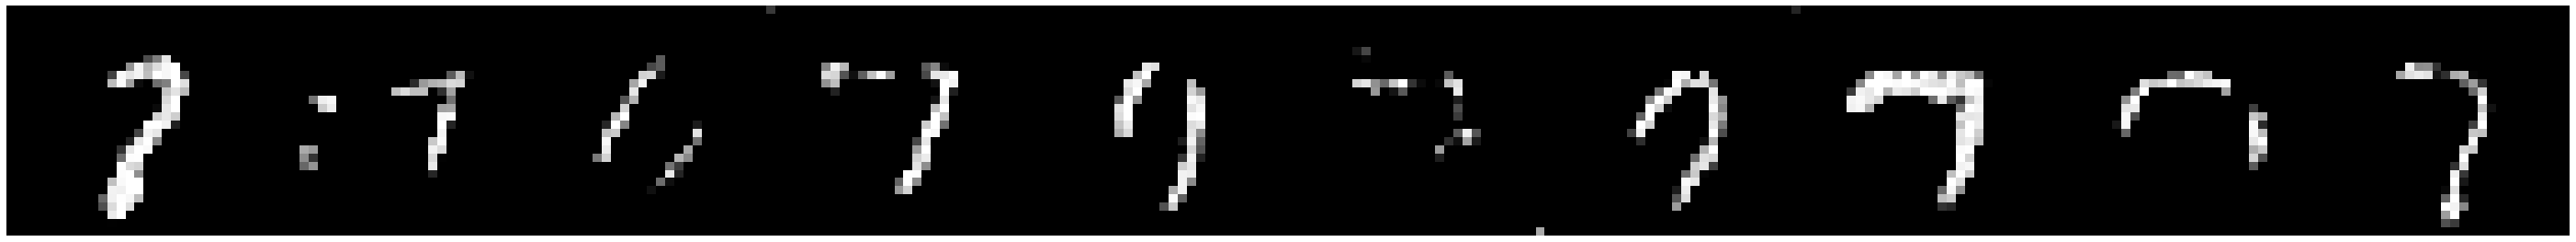

Sampling class: 4


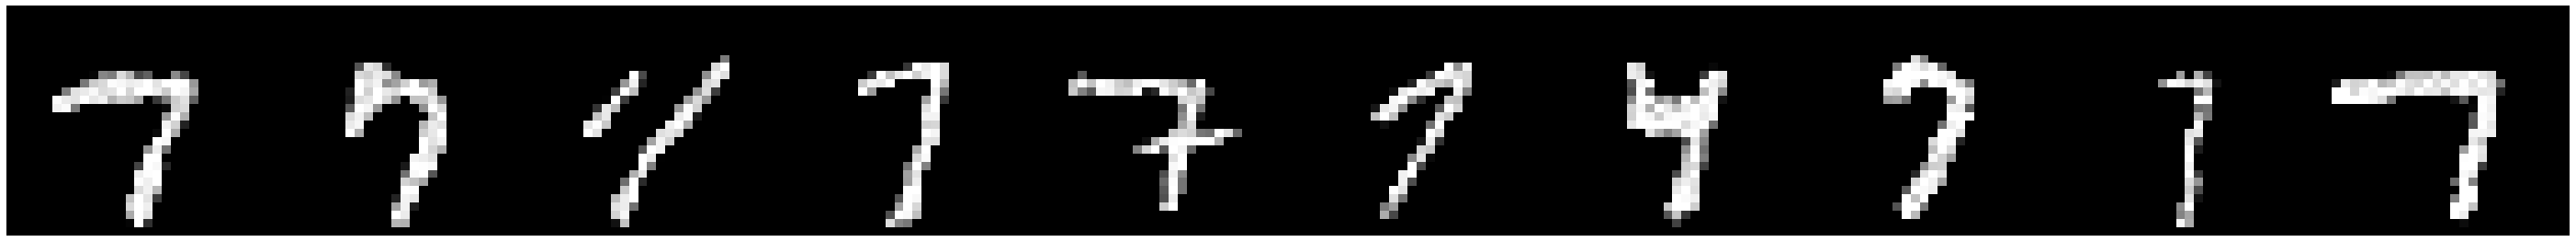

Sampling class: 9


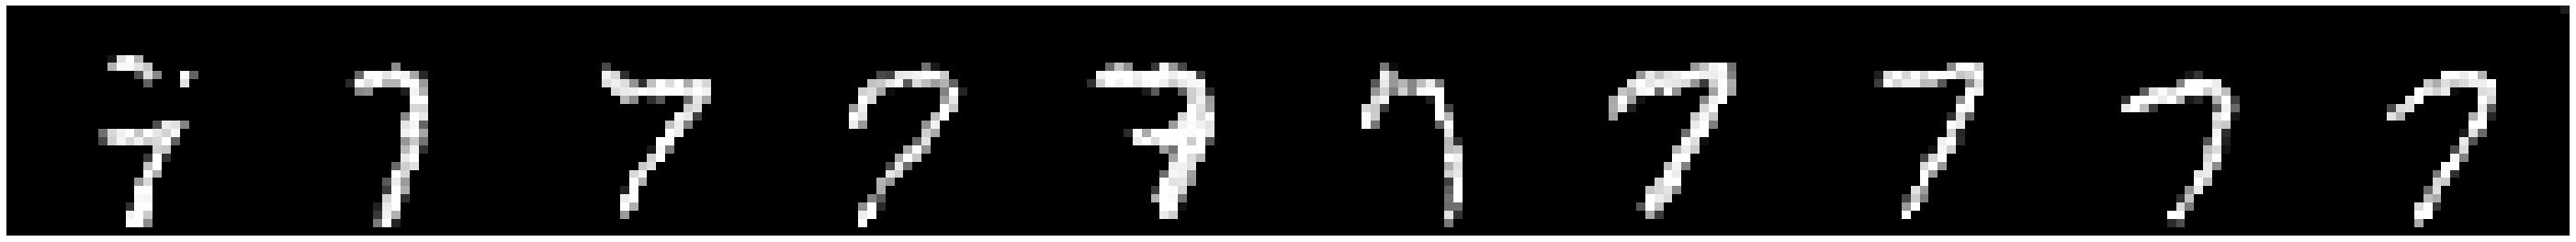

Sampling class: 7


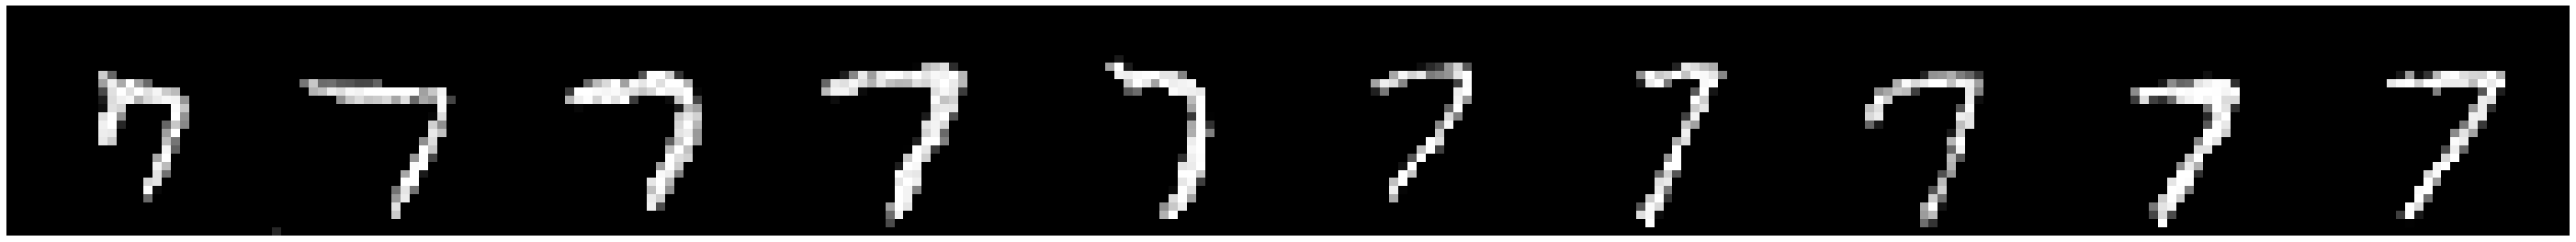

In [14]:
label_guided_afterone_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_afterone_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_afterone_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 1), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "mnist_class_extension_label_guided_after7_%d.svg" % class_to_sample),
        format="svg"
    )
    plt.show()

Sampling class: 0


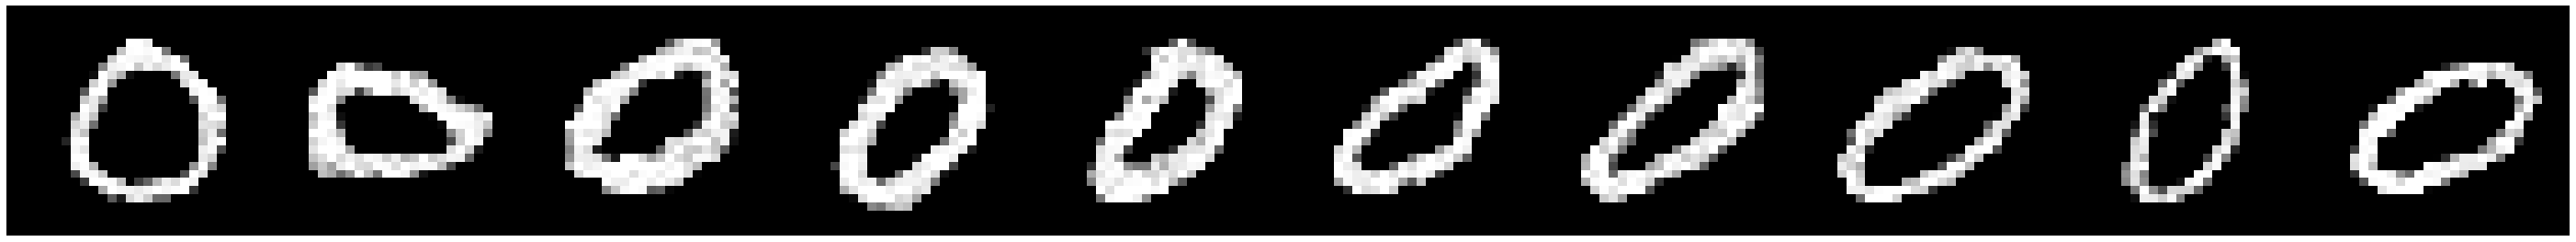

Sampling class: 4


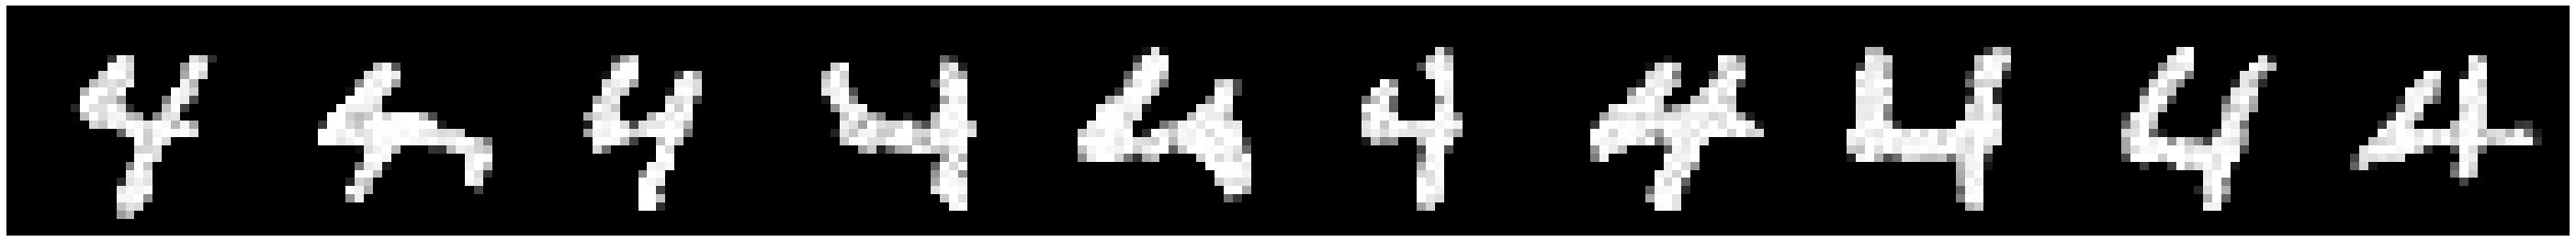

Sampling class: 9


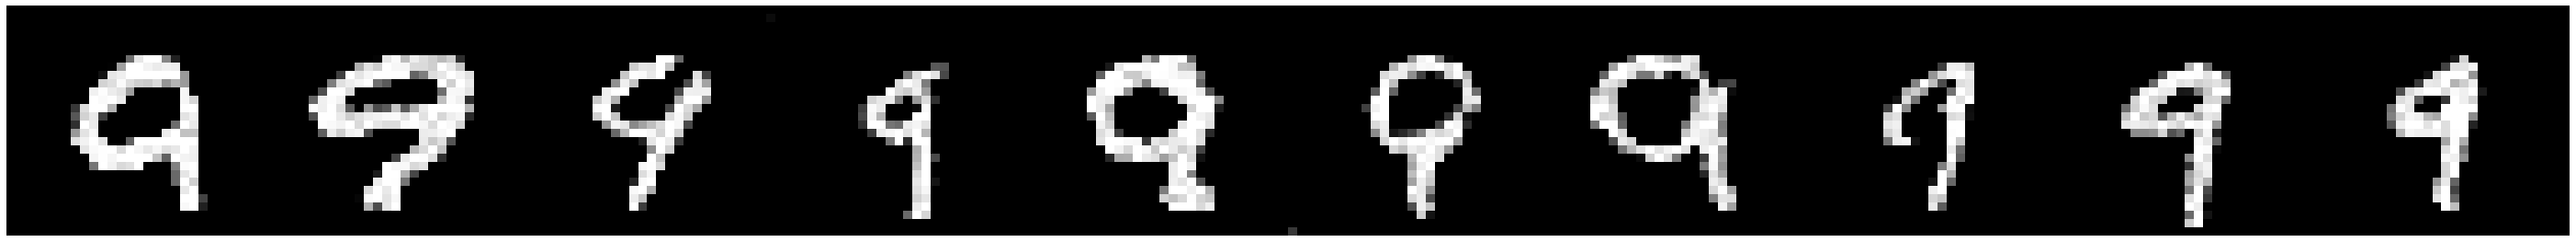

Sampling class: 7


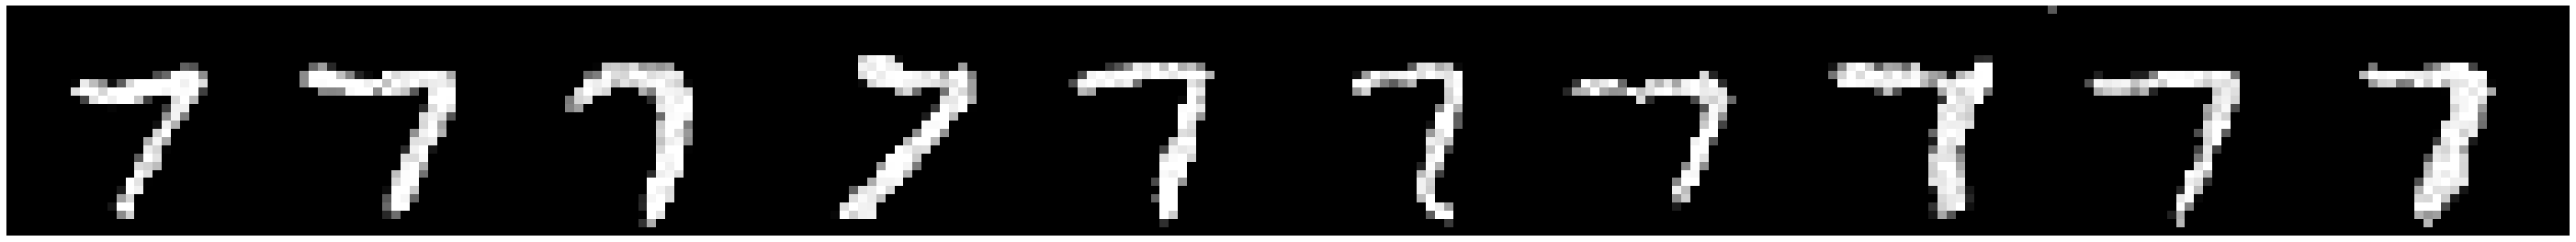

In [15]:
label_guided_afterall_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_afterall_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes_0497),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_afterall_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 1), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "mnist_class_extension_label_guided_afterall_%d.svg" % class_to_sample),
        format="svg"
    )
    plt.show()

**Compare FIDs**

In [18]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes_0497:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset_0497.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((dataset_0497.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 4
Sampling class: 9
Sampling class: 7


In [20]:
branched_before_fids = {}
branched_after_fids = {}
label_guided_before_fids = {}
label_guided_afterone_fids = {}
label_guided_afterall_fids = {}

for c in branched_before_samples.keys():
    branched_before_fids[c] = compute_fid(branched_before_samples[c], true_samples[c])
for c in branched_after_samples.keys():
    branched_after_fids[c] = compute_fid(branched_after_samples[c], true_samples[c])
for c in label_guided_before_samples.keys():
    label_guided_before_fids[c] = compute_fid(label_guided_before_samples[c], true_samples[c])
for c in label_guided_afterone_samples.keys():
    label_guided_afterone_fids[c] = compute_fid(label_guided_afterone_samples[c], true_samples[c])
for c in label_guided_afterall_samples.keys():
    label_guided_afterall_fids[c] = compute_fid(label_guided_afterall_samples[c], true_samples[c])

In [21]:
print(branched_before_fids)
print(branched_after_fids)
print(label_guided_before_fids)
print(label_guided_afterone_fids)
print(label_guided_afterall_fids)

{0: 23.262932678901493, 4: 16.93472286346435, 9: 17.880786877050035}
{0: 22.767332410601696, 4: 15.890384463452714, 9: 18.005306687801983, 7: 24.17460249587286}
{0: 43.76577030853884, 4: 43.79808348434176, 9: 41.51376057896882, 7: 300.5974901426579}
{0: 218.3260000802342, 4: 108.64616057076938, 9: 104.1053352473601, 7: 29.894016774353965}
{0: 46.6613347468438, 4: 38.78937387955358, 9: 29.705318500117755, 7: 20.949919516716598}


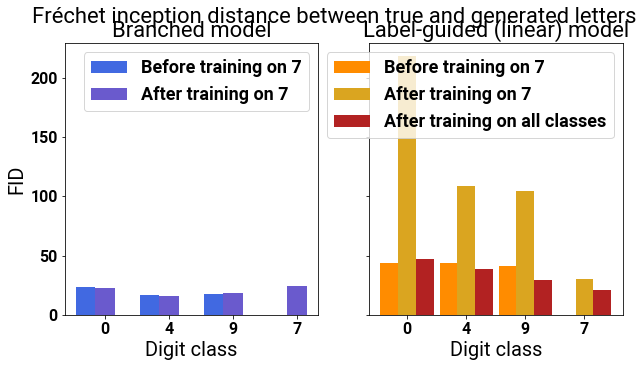

In [22]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

bar_width = 0.3
x = np.arange(len(branched_after_fids))

branched_before_vals = [branched_before_fids[c] for c in classes_049] + [0]
branched_after_vals = [branched_after_fids[c] for c in classes_0497]
ax[0].bar(
    x, branched_before_vals, bar_width, label="Before training on 7", color="royalblue"
)
ax[0].bar(
    x + bar_width, branched_after_vals, bar_width, label="After training on 7", color="slateblue"
)
ax[0].set_title("Branched model")

label_guided_before_vals = [label_guided_before_fids[c] for c in classes_049] + [0]
label_guided_afterone_vals = [label_guided_afterone_fids[c] for c in classes_0497]
label_guided_afterall_vals = [label_guided_afterall_fids[c] for c in classes_0497]
ax[1].bar(
    x, label_guided_before_vals, bar_width, label="Before training on 7", color="darkorange"
)
ax[1].bar(
    x + bar_width, label_guided_afterone_vals, bar_width, label="After training on 7", color="goldenrod"
)
ax[1].bar(
    x + (2 * bar_width), label_guided_afterall_vals, bar_width, label="After training on all classes", color="firebrick"
)
ax[1].set_title("Label-guided (linear) model")
for i in range(2):
    ax[i].set_xticks(x + bar_width, labels=[c for c in classes_0497])
    ax[i].set_xlabel("Digit class")
    ax[i].legend()
ax[0].set_ylabel("FID")
fig.suptitle("Fréchet inception distance between true and generated letters")
fig.savefig(
    os.path.join(out_path, "digit_fid.svg"),
    format="svg"
)
plt.show()